### Notebook for analysing nf pipeline output

#### Sequencing batch 9

### Sequencing information 
 - Analysis no.: A003-service
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext FS and NEBNext
 - Seq Date: 30-04-2021
 - Number of samples:76

In [4]:
base_dir = '/home/douso/Kibet/2021-04-30_run6_KEM'

FileNotFoundError: [Errno 2] No such file or directory: '/home/douso/Kibet/2021-04-30_run6_KEM/KEM-21-03-94512_S24.trim.mkD.amplicon.regions.coverage.tsv'

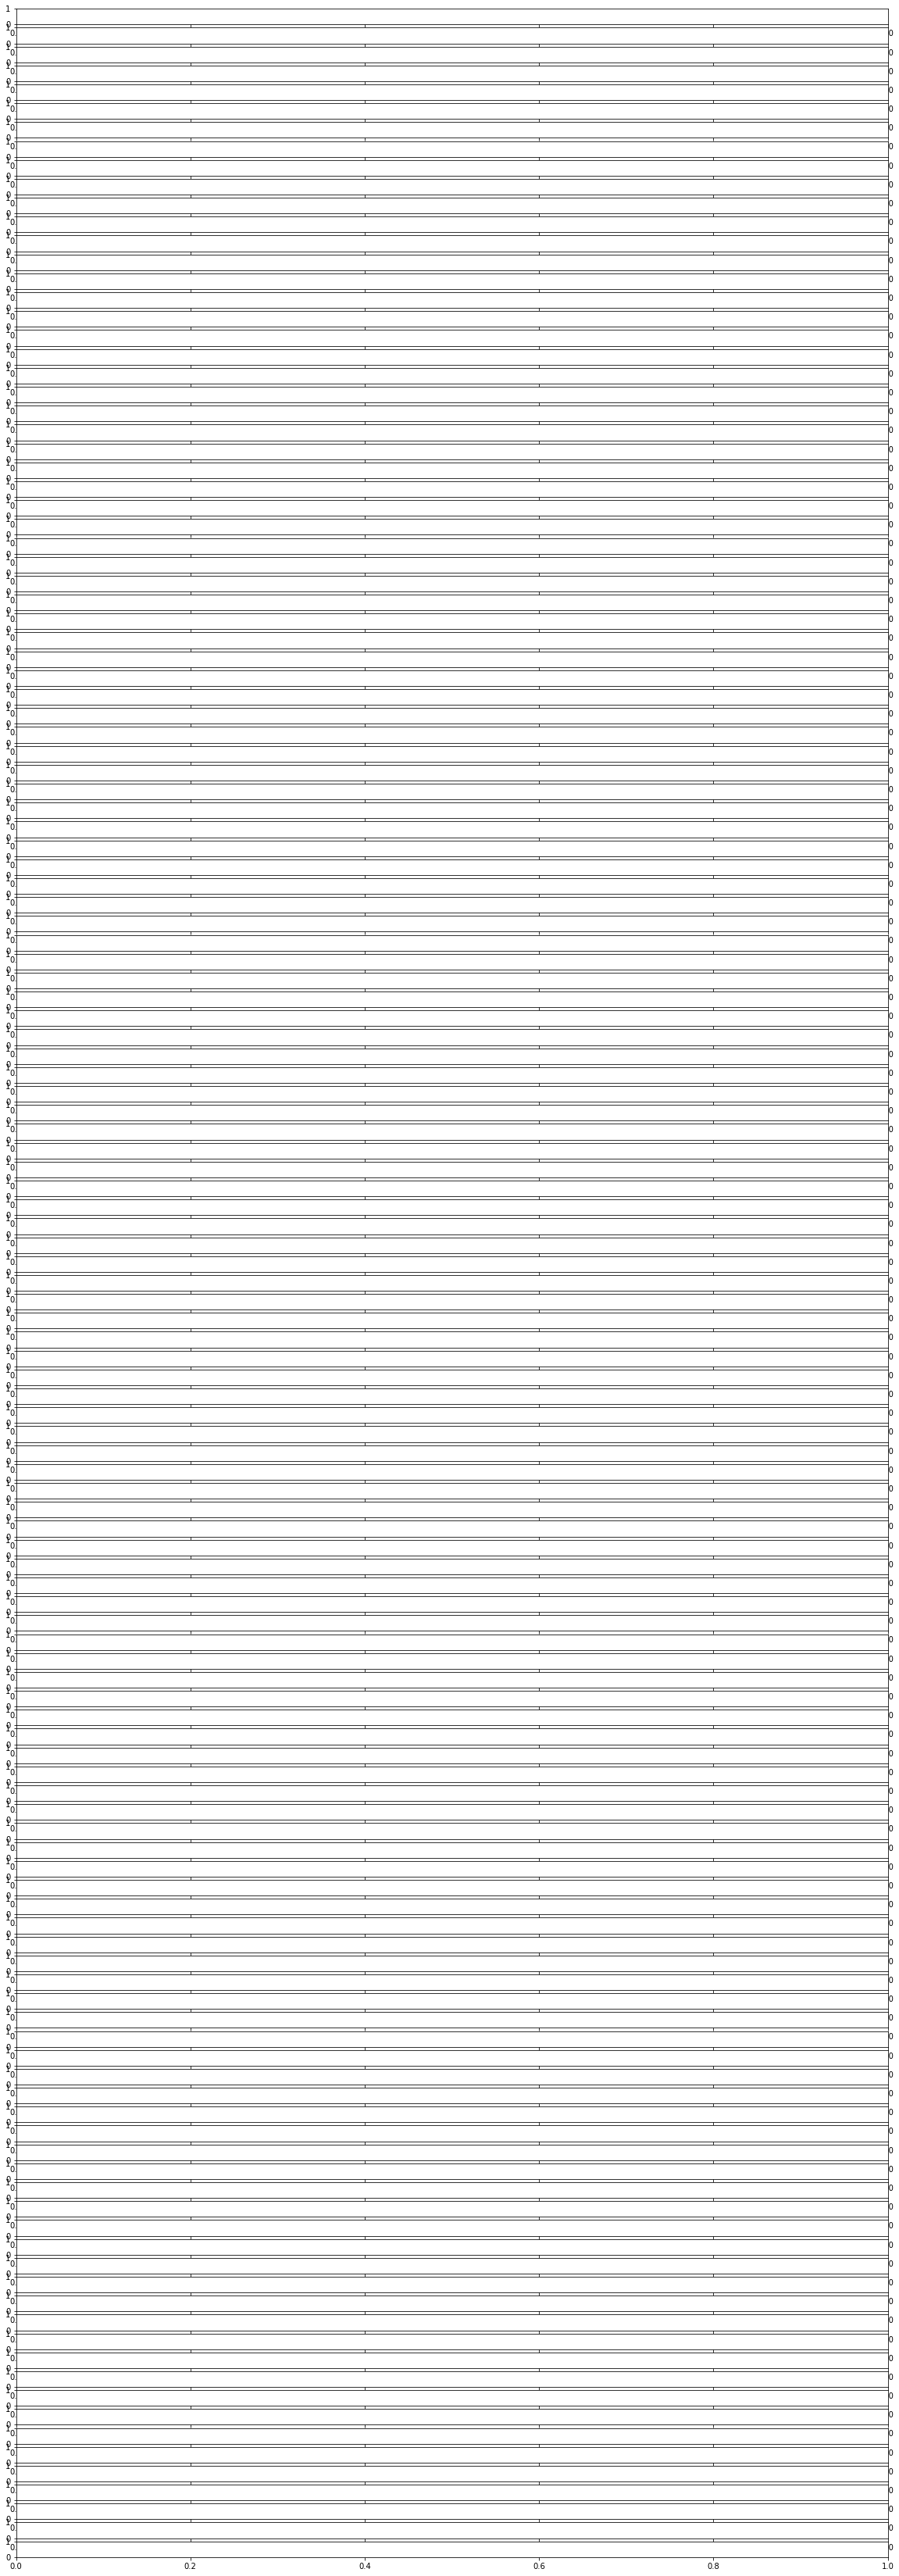

In [5]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
files = os.listdir(f'{base_dir}/dpt')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,60)) 

xtick = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


In [ ]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt

suffix = '.genome.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/2021-04-30_run6_NPHL_COVC/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 60))

xtick = range(0, 30000, 500)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot.bar(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
# plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob, os

In [7]:
base_dir = '/home/douso/Kibet/2021-04-30_run6_KEM'
batch = 'seq9'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

## Analysis of batch 3 and 4 
### Sequencing information 
 - Analysis no.: NF-002-service (batch 9)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext (FS and non-FS)
 - Seq Date: MiSeq (30-04-2021)
 - Number of samples: 150
 - Sample summ: KEM-21
 - VC pipeline: nextflow-viralcon

## Functions

In [43]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.capitalize().replace(' ', '_') for col in df.columns]
    return df

In [9]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [10]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [11]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.merge(df_nxt_cln, how='outer', left_on='sample_name', right_on='seqName')
                 .drop('seqName', axis=1))

In [12]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.merge(df_varNxt, how='left', left_on='Sequence_name', right_on='sample_name')
            .drop('sample_name', axis=1))

In [13]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.merge(df_cts_cln, left_on='Sample_No', right_on='Sample_Name')
            .drop('Sample_Name', axis=1))


In [51]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.merge(df_rmdCts, how='left', left_on='Sequence_name', right_on='Sample_number')
                 .drop('Sample_number', axis=1))

In [15]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [16]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [ ]:
df_var_fnl.head()

### Nextclade data

In [17]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/run6_KEM_con.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [ ]:
df_nxt_fnl.head()

### Pangolin data v.2.4.2 (25-04-2021)

In [18]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/run6_KEM_con.pangolin.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_cln1 = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months)))

In [ ]:
df_png_fnl.head()

# Metadata

In [23]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results'
df_rmd = pd.read_excel(f'{mbase_dir}/seq-kemri-150samples.xlsx', header=1)

In [24]:
df_rmd.head()

PLATE NUMBER  S/No    SAMPLE NUMBER SAMPLE TYPE (e.g. NP/OP, Blood)  \
0           A1   1.0  KEM-21-03-93738                    NP & OP Swab   
1           A2   2.0  KEM-21-03-93999                    NP & OP Swab   
2           A3   3.0  KEM-21-03-94391                    NP & OP Swab   
3           A4   4.0  KEM-21-03-94418                    NP & OP Swab   
4           A5   5.0  KEM-21-03-94511                    NP & OP Swab   

   OCCUPATION DATE OF SAMPLE COLLECTION  DATE SAMPLE RECEIVED IN THE LAB  \
0         NaN       2021-03-03 00:00:00                              NaN   
1         NaN                02/03/2021                              NaN   
2         NaN       2021-02-03 00:00:00                              NaN   
3         NaN                04/03/2021                              NaN   
4         NaN                09/03/2021                              NaN   

  LAB CONFIRMATION DATE Cycle threshold (Ct) value  Average_Ct  ...  \
0   2021-05-03 00:00:00                  18.2/19.3        18.8  ...   
1            10/03/2021                  22.3/18.6        20.5  ...   
2            11/03/2021                  26.1/21.3        23.7  ...   
3            11/03/2021                  11.4/21.5        16.5  ...   
4            11/03/2021                  26.3/28.0        27.2  ...   

  NATIONALITY HAS TRAVEL HOSTORY(LAST 14 DAYS) Y/N TRAVEL FROM  \
0       Kenya                                   No         NaN   
1       Kenya                                   No         NaN   
2       Kenya                                   No         NaN   
3       Kenya                                   No         NaN   
4       Kenya                                   No         NaN   

  QUARANTINE FACILITY/HOSPITAL/HOMESTEAD  COUNTY OF DIAGNOSIS  \
0                                    NaN              Kiambu    
1                                    NaN             Nairobi    
2                                    NaN               Kiambu   
3                                    NaN              Kiambu    
4                                    NaN             Nairobi    

  COUNTY OF RESIDENCE SUB COUNTY OF RESIDENCE        TESTING LAB  \
0             Kiambu                   Kahoho  KEMRI VHF/FLU LAB   
1             Kiambu               Githunguri  KEMRI VHF/FLU LAB   
2             Kiambu                   Thika   KEMRI VHF/FLU LAB   
3             Kiambu                    Thika  KEMRI VHF/FLU LAB   
4             Kiambu                    Thika  KEMRI VHF/FLU LAB   

  REASON FOR TESTING: 1. Surveillance  2. Air travel 3. Truck Driver 4. Others  \
0                                                1.0                             
1                                                1.0                             
2                                                1.0                             
3                                                1.0                             
4                                                1.0                             

     RESULT  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive  

[5 rows x 27 columns]

In [46]:
cols = ['Sample_number',
 'Age',
 'Age_unit_(days/months/years)',
 'Gender_(m/f)',
 'Occupation',
 'Nationality',
 'County_of_residence',
 'Has_travel_hostory(last_14_days)_y/n',
 'Travel_from',
 'Quarantine_facility/hospital/homestead',
 'Symtoms_shown_(cough;fever;etc)',
 'Date_of_sample_collection',
 'Date_sample_received_in_the_lab',
 'Result',
 'Lab_confirmation_date',
 'Average_ct']
df_rmdCts = get_cols(tidy_header(df_rmd), cols)

In [69]:
df_rmdCts.shape

(152, 16)

### Combining data

#### Merge Variants and Nextclade data

In [33]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [34]:
df_varNxt.head()

sample_name  num_vars  \
0  KEM-21-03-94648      32.0   
1  KEM-21-03-94512      31.0   
2  KEM-21-03-95532      34.0   
3  KEM-21-03-95596      18.0   
4  KEM-21-03-93952      36.0   

                                              ORF1ab  ORF1a  \
0  R24R, S216S, F924F, T1001I, A1708D, F1907F, S3...    NaN   
1  R24R, S216S, T1001I, A1708D, M2194L, S3675_F36...    NaN   
2  S216S, N615N, F924F, T1001I, A1708D, F1907F, S...    NaN   
3  V5V, P193L, S216S, L642F, I1877M, K1878Q, W201...    NaN   
4  S216S, N615N, L766L, F924F, T1001I, A1708D, F1...    NaN   

                                                   S ORF3a  ORF3b    E     M  \
0  H69_V70del, Y145del, N501Y, A570D, D614G, P681...   NaN    NaN  NaN   NaN   
1        Y145del, Y144D, A570D, D614G, L753*, D1118H   NaN    NaN  NaN   NaN   
2  H69_V70del, Y145del, N501Y, A570D, D614G, P631...   NaN    NaN  NaN  N41N   
3                                                NaN  L84L    NaN  NaN   NaN   
4  H69_V70del, Y145del, N501Y, A570D, D614G, N679...   NaN    NaN  NaN   NaN   

  ORF6 ORF7a  ORF7b                    ORF8  \
0  NaN   NaN    NaN  Q27*, R52I, K68*, Y73C   
1  NaN   NaN    NaN        Q27*, R52I, Y73C   
2  NaN   NaN    NaN  Q27*, R52I, K68*, Y73C   
3  NaN   NaN    NaN                    Y73C   
4  NaN   NaN    NaN  Q27*, R52I, K68*, Y73C   

                                           N  ORF9a  ORF9b  ORF10  \
0  D3H, D3V, D3E, R203K, R203R, G204R, S235F    NaN    NaN    NaN   
1  D3H, D3V, D3E, R203K, R203R, G204R, S235F    NaN    NaN    NaN   
2  D3H, D3V, D3E, R203K, R203R, G204R, S235F    NaN    NaN    NaN   
3                              D3H, D3V, D3E    NaN    NaN    NaN   
4  D3H, D3V, D3E, R203K, R203R, G204R, S235F    NaN    NaN    NaN   

         clade  coverage  
0          NaN       NaN  
1  20I/501Y.V1      58.9  
2          NaN       NaN  
3  20I/501Y.V1      15.6  
4  20I/501Y.V1      95.0

#### Merge pango and var-nextclade data

In [35]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [82]:
df_pngVxt.head()

Sequence_name  Lineage      Date_range        Most_common_countries  \
0     COVC20893      B.1  Jan-24, Apr-13               USA, UK, Spain   
1     COVC20899  B.1.530  Oct-28, Jan-25  Kenya, Denmark, Netherlands   
2     COVC20900      B.1  Jan-24, Apr-13               USA, UK, Spain   
3     COVC20901      B.1  Jan-24, Apr-13               USA, UK, Spain   
4     COVC21003      B.1  Jan-24, Apr-13               USA, UK, Spain   

   num_vars                                             ORF1ab  ORF1a  \
0        10       K680N, F924F, V4677I, D4697G, L4715L, R5947M    NaN   
1        15  F924F, E940D, Q1009R, R3480K, V3595V, L4577F, ...    NaN   
2        20  E102Q, T265I, F924F, D953Y, K3353R, A3755A, N4...    NaN   
3        14        E102Q, T265I, F924F, S2535L, K3353R, L4715L    NaN   
4        15  L61L, E102Q, T265I, F924F, T2910I, K3353R, L4715L    NaN   

                          S        ORF3a  ORF3b  ...  ORF6 ORF7a ORF7b  \
0              D614G, P728P         L83F    NaN  ...   NaN   NaN   NaN   
1              D614G, P681H         A99S    NaN  ...   NaN   NaN   NaN   
2     D614G, L1200L, Q1201K  Q57H, Y113Y    NaN  ...   NaN   NaN   NaN   
3   D614G, L1200L, Q1201K,          Q57H    NaN  ...   NaN   NaN   NaN   
4  V70V, D80Y, S375S, D614G         Q57H    NaN  ...   NaN   NaN   NaN   

               ORF8                   N ORF9a ORF9b  ORF10  clade coverage  
0               NaN               S206F   NaN   NaN    NaN    20A     93.3  
1              S69P        T205I, L400L   NaN   NaN    NaN    20A     93.3  
2  A14T, A51V, V62L  P13S, R195K, P207T   NaN   NaN   N25N    20C     95.7  
3        A14T, V62L                P13S   NaN   NaN   N25N    20C     83.3  
4               NaN  P13S, R195K, P207T   NaN   NaN    NaN    20C     87.4  

[5 rows x 22 columns]

#### Merge the metadata and Cts data

In [38]:
df_rmdCts.head()

Sample_number   Age Age_unit_(days/months/years) Gender_(m/f)  \
0  KEM-21-03-93738  42.0                        Years            F   
1  KEM-21-03-93999  55.0                        Years            F   
2  KEM-21-03-94391  70.0                        Years            F   
3  KEM-21-03-94418  31.0                        Years            F   
4  KEM-21-03-94511  18.0                        Years            M   

   Occupation Nationality County_of_residence  \
0         NaN       Kenya             Kiambu    
1         NaN       Kenya             Kiambu    
2         NaN       Kenya             Kiambu    
3         NaN       Kenya             Kiambu    
4         NaN       Kenya             Kiambu    

  Has_travel_hostory(last_14_days)_y/n Travel_from  \
0                                   No         NaN   
1                                   No         NaN   
2                                   No         NaN   
3                                   No         NaN   
4                                   No         NaN   

   Quarantine_facility/hospital/homestead Symtoms_shown_(cough;fever;etc)  \
0                                     NaN                             NaN   
1                                     NaN                General weakness   
2                                     NaN                             NaN   
3                                     NaN                             NaN   
4                                     NaN                   Loss of taste   

  Date_of_sample_collection  Date_sample_received_in_the_lab    Result  \
0       2021-03-03 00:00:00                              NaN  Positive   
1                02/03/2021                              NaN  Positive   
2       2021-02-03 00:00:00                              NaN  Positive   
3                04/03/2021                              NaN  Positive   
4                09/03/2021                              NaN  Positive   

  Lab_confirmation_date  Average_ct  
0   2021-05-03 00:00:00        18.8  
1            10/03/2021        20.5  
2            11/03/2021        23.7  
3            11/03/2021        16.5  
4            11/03/2021        27.2

#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [52]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [53]:
df_vnpPmd.head()

Sequence_name  Lineage      Date_range Most_common_countries  num_vars  \
0  KEM-21-03-93738  B.1.1.7  Sep-20, Feb-21   UK, Denmark, France      40.0   
1  KEM-21-03-93872  B.1.1.7  Sep-20, Feb-21   UK, Denmark, France      33.0   
2  KEM-21-03-93899  B.1.1.7  Sep-20, Feb-21   UK, Denmark, France      31.0   
3  KEM-21-03-93912  B.1.1.7  Sep-20, Feb-21   UK, Denmark, France      36.0   
4  KEM-21-03-93916  B.1.1.7  Sep-20, Feb-21   UK, Denmark, France      39.0   

                                              ORF1ab  ORF1a  \
0  S216S, N615N, L766L, F924F, T1001I, A1708D, F1...    NaN   
1  S216S, L730F, F924F, T1001I, E1341D, A1708D, F...    NaN   
2  S216S, F924F, T1001I, A1708D, F1907F, S3675_F3...    NaN   
3  S216S, N615N, F924F, T1001I, A1708D, F1907F, I...    NaN   
4  S216S, N615N, T1001I, A1708D, F1907F, D2573D, ...    NaN   

                                                   S ORF3a  ORF3b  ...  \
0  H69_V70del, Y145del, N501Y, A570D, D614G, P681...   NaN    NaN  ...   
1  H69_V70del, Y145del, N501Y, A570D, D614G, P681...   NaN    NaN  ...   
2  H69_V70del, Y145del, N501Y, A570D, D614G, P681...   NaN    NaN  ...   
3  H69_V70del, Y145del, N501Y, A570D, D614G, P681...   NaN    NaN  ...   
4  H69_V70del, Y145del, N501Y, A570D, D614G, P681...   NaN    NaN  ...   

  County_of_residence Has_travel_hostory(last_14_days)_y/n Travel_from  \
0             Kiambu                                    No         NaN   
1            Nairobi                                    No         NaN   
2            Nairobi                                    No         NaN   
3            Nairobi                                    No         NaN   
4             Kiambu                                    No         NaN   

  Quarantine_facility/hospital/homestead  Symtoms_shown_(cough;fever;etc)  \
0                                    NaN                              NaN   
1                                    NaN                              NaN   
2                                    NaN                              NaN   
3                                    NaN                              NaN   
4                                    NaN                              NaN   

  Date_of_sample_collection Date_sample_received_in_the_lab    Result  \
0       2021-03-03 00:00:00                             NaN  Positive   
1       2021-02-03 00:00:00                             NaN  Positive   
2       2021-03-03 00:00:00                             NaN  Positive   
3       2021-03-03 00:00:00                             NaN  Positive   
4       2021-03-03 00:00:00                             NaN  Positive   

   Lab_confirmation_date  Average_ct  
0    2021-05-03 00:00:00        18.8  
1    2021-04-03 00:00:00        25.9  
2    2021-04-03 00:00:00        21.3  
3    2021-04-03 00:00:00        25.5  
4    2021-04-03 00:00:00        27.7  

[5 rows x 37 columns]

#### QC whether all samples sequenced had metadata

In [54]:
codes_fnl = set(df_vnpPmd['Sequence_name'])
codes_metadata = set(df_rmdCts['Sample_number'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'KEM'}


These sample codes were in the sequencing data but not on the metadata. `NPHLs` didn't have metadata
 - NPHL3
 - NPHL4
 - NPHL2
 - NPHL-12773
 - NPHL1
 - NPHL-12756

#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [55]:
df_vnpPmd.columns

Index(['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage', 'Age', 'Age_unit_(days/months/years)', 'Gender_(m/f)',
       'Occupation', 'Nationality', 'County_of_residence',
       'Has_travel_hostory(last_14_days)_y/n', 'Travel_from',
       'Quarantine_facility/hospital/homestead',
       'Symtoms_shown_(cough;fever;etc)', 'Date_of_sample_collection',
       'Date_sample_received_in_the_lab', 'Result', 'Lab_confirmation_date',
       'Average_ct'],
      dtype='object')

In [56]:
header_kem = ['Sequence_name', 'Age', 'Age_unit_(days/months/years)', 'Gender_(m/f)',
              'Occupation', 'Nationality', 'County_of_residence',
              'Has_travel_hostory(last_14_days)_y/n', 'Travel_from',
              'Quarantine_facility/hospital/homestead',
              'Symtoms_shown_(cough;fever;etc)', 'Date_of_sample_collection',
              'Date_sample_received_in_the_lab', 'Result', 'Lab_confirmation_date',
              'Average_ct', 'Lineage', 'Most_common_countries', 'Date_range', 
              'clade', 'coverage', 'num_vars', 'S', 'ORF1ab', 'ORF1a', 'ORF3a', 
              'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 
              'ORF9b', 'ORF10']

In [65]:
len(header_kem)

37

In [64]:
cols_rename = ['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'M_COMM_C', 'DT_RANG', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [66]:
len(cols_rename)

37

In [89]:
header = ['Sequence_name', 'Lineage', 'Most_common_countries', 'Date_range'
          , 'num_vars', 'S', 'clade','coverage', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
          , 'Date_of_Onset_of_symptoms', 'Symptoms_shown', 'Sample_Type'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct', 'ORF1ab', 'ORF1a'
          , 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N'
          , 'ORF9a', 'ORF9b', 'ORF10']

In [58]:
header2 = ['Sequence_name', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
          , 'Symptoms_shown'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct', 'Lineage'
          , 'Most_common_countries', 'Date_range', 'clade','coverage'
          , 'num_vars', 'S',  'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E'
          , 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [91]:
header3 = ['Sequence_name', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility', 'Symptoms_shown'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct']

In [63]:
len(cols_rename)

16

In [118]:
df_vnpPmd_fnl = df_vnpPmd[header3]
# df_vnpPmd_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M003.xlsx'
#                      , index=False, na_rep='N/A', float_format='%.1f')

In [67]:
df_vnpPmd_fnl = df_vnpPmd[header_kem]
# df_vnpPmd_fnl.to_excel('/home/douso/SarsGenomics/Processed/metadata-serv-seq-MS003.xlsx'
#                      , index=False, na_rep='NA', float_format='%.1f', header=cols_rename)
df_vnpPmd_fnl.head()

Sequence_name   Age Age_unit_(days/months/years) Gender_(m/f)  \
0  KEM-21-03-93738  42.0                        Years            F   
1  KEM-21-03-93872  41.0                        Years            M   
2  KEM-21-03-93899  54.0                        Years            F   
3  KEM-21-03-93912  35.0                        Years            F   
4  KEM-21-03-93916  12.0                        Years            F   

   Occupation Nationality County_of_residence  \
0         NaN       Kenya             Kiambu    
1         NaN       Kenya            Nairobi    
2         NaN       Kenya            Nairobi    
3         NaN       Kenya            Nairobi    
4         NaN       Kenya             Kiambu    

  Has_travel_hostory(last_14_days)_y/n Travel_from  \
0                                   No         NaN   
1                                   No         NaN   
2                                   No         NaN   
3                                   No         NaN   
4                                   No         NaN   

   Quarantine_facility/hospital/homestead  ...    E      M  ORF6 ORF7a ORF7b  \
0                                     NaN  ...  NaN    NaN   NaN   NaN   NaN   
1                                     NaN  ...  NaN  T175T   NaN   NaN   NaN   
2                                     NaN  ...  NaN    NaN   NaN   NaN   NaN   
3                                     NaN  ...  NaN    NaN   NaN   NaN   NaN   
4                                     NaN  ...  NaN    NaN   NaN   NaN   NaN   

                     ORF8                                                 N  \
0  Q27*, R52I, K68*, Y73C  D3H, D3V, D3E, T135I, R203K, R203R, G204R, S235F   
1        Q27*, R52I, Y73C         D3H, D3V, D3E, R203K, R203R, G204R, S235F   
2  Q18H, Q27*, R52I, Y73C         D3H, D3V, D3E, R203K, R203R, G204R, S235F   
3  Q27*, R52I, K68*, Y73C  D3H, D3V, D3E, R203K, R203R, G204R, S235F, D288D   
4  Q27*, R52I, K68*, Y73C  D3H, D3V, D3E, R203K, R203R, G204R, S235F, D415D   

  ORF9a ORF9b ORF10  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 37 columns]

In [ ]:
clr_code = {'B.1.1.7': ('orange', '#FFA500'),
            'B.1.525': ('green', '#008000'), 
            'B.1.351': ('blue', '#0000FF'),
            'B.1.549': ('brown', '#A52A2A'),
            'A.23.1': ('gray', '#808080'),
            'B.1.596.1': ('magenta', '#FF00FF'),
            'B.1': ('cyan', '#00FFFF'),
            'B.1.530': ('red', '#FF0000'),
            'A.23': ('lime', '#00FF00'),
            'B.1.143': ('olive', '#808000'),
            'B.1.1.171': ('teal', '#008080'),
            'B.1.343': ('indigo', '#4B0082'),
            'B.1.388': ('sienna', '#A0522D')
            'TBA1': ('sienna', '#A0522D'),
            'TBA2': ('chocolate', '#D2691E'),
            'TBA3': ('chocolate', '#D2691E'),
            'TBA3': ('rosybrown', '#BC8F8F'),
            'TBA4': ('wheat', '#F5DEB3'),
            'TBA5': ('slategray', '#708090'),
            'TBA6': ('palevioletred', '#DB7093'),
            'TBA7': ('mediumpurple', '#9370DB'),
            'TBA8': ('tan', '#D2B48C'),
            'TBA9': ('aquamarine', '#7FFFD4')}

clr_lin = {'B.1.1.7': '#FFA500', 'B.1.525': '#008000', 'B.1.351': '#0000FF'
            , 'B.1.549': '#A52A2A', 'A.23.1': '#808080', 'B.1.596.1': '#FF00FF',
       'B.1': '#00FFFF', 'B.1.530': '#FF0000', 'A.23': '#00FF00', 'B.1.143': '#808000', 
       'B.1.1.171': '#008080', 'B.1.343': '#4B0082', 'B.1.388': '#A0522D'}

In [115]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

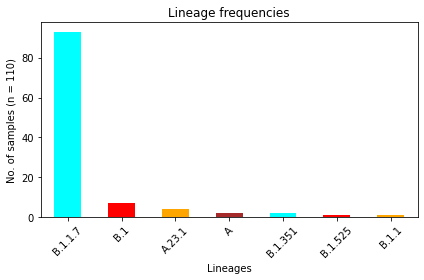

In [68]:
# plot lineage frequencies
colors = ['#00FFFF', '#FF0000', '#FFA500', '#A52A2A']
n = df_vnpPmd_fnl['Lineage'].count()
fig, ax = plt.subplots()
(df_vnpPmd_fnl['Lineage']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.xticks(rotation=45)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P003.png', dpi=300.0)
plt.show()

In [ ]:
clr_code = {'B.1.1.7': ('orange', '#FFA500'),
            'B.1.525': ('green', '#008000'), 
            'B.1.351': ('blue', '#0000FF'),
            'B.1.549': ('brown', '#A52A2A'),
            'A.23.1': ('gray', '#808080'),
            'B.1.596.1': ('magenta', '#FF00FF'),
            'B.1': ('cyan', '#00FFFF'),
            'B.1.530': ('red', '#FF0000'),
            'A.23': ('lime', '#00FF00'),
            'B.1.143': ('olive', '#808000'),
            'B.1.1.171': ('teal', '#008080'),
            'B.1.343': ('indigo', '#4B0082'),
            'B.1.388': ('sienna', '#A0522D')
            'TBA1': ('sienna', '#A0522D'),
            'TBA2': ('chocolate', '#D2691E'),
            'TBA3': ('chocolate', '#D2691E'),
            'TBA3': ('rosybrown', '#BC8F8F'),
            'TBA4': ('wheat', '#F5DEB3'),
            'TBA5': ('slategray', '#708090'),
            'TBA6': ('palevioletred', '#DB7093'),
            'TBA7': ('mediumpurple', '#9370DB'),
            'TBA8': ('tan', '#D2B48C'),
            'TBA9': ('aquamarine', '#7FFFD4')}

clr_lin = {'B.1.1.7': '#FFA500', 'B.1.525': '#008000', 'B.1.351': '#0000FF'
            , 'B.1.549': '#A52A2A', 'A.23.1': '#808080', 'B.1.596.1': '#FF00FF',
       'B.1': '#00FFFF', 'B.1.530': '#FF0000', 'A.23': '#00FF00', 'B.1.143': '#808000', 
       'B.1.1.171': '#008080', 'B.1.343': '#4B0082', 'B.1.388': '#A0522D'}